In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install natsort

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os

from matplotlib.patches import Rectangle
from natsort import natsorted
from tqdm import tqdm

%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import *

In [ ]:
os.chdir('/content/drive/MyDrive/EE113DB - Sagar')
print(os.getcwd())

dataDir = 'custom_datasets320'
dataType = 'val2017'

img_filenames = natsorted(os.listdir(os.path.join(dataDir, 'images', dataType)))
img_ids = [os.path.splitext(f)[0] for f in img_filenames] # get rid of '.jpg' extension

/content/drive/MyDrive/EE113DB - Sagar


In [ ]:
# based on https://github.com/experiencor/keras-yolo3
import numpy as np
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle
 
class BoundBox:
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1
 
	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)
 
		return self.label
 
	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]
 
		return self.score
 
def _sigmoid(x):
	return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
  grid_h, grid_w = netout.shape[:2]
  nb_box = 3
  netout = netout.reshape((grid_h, grid_w, nb_box, -1)) # Converts to 
  nb_class = netout.shape[-1] - 5
  boxes = []
  netout[..., :2]  = _sigmoid(netout[..., :2])
  netout[..., 4:]  = _sigmoid(netout[..., 4:])
  netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
  netout[..., 5:] *= netout[..., 5:] > obj_thresh

  for i in range(grid_h*grid_w):
    row = i / grid_w
    col = i % grid_w
    for b in range(nb_box):
      # 4th element is objectness score
      objectness = netout[int(row)][int(col)][b][4]
      if(objectness.all() <= obj_thresh): continue
      # first 4 elements are x, y, w, and h
      x, y, w, h = netout[int(row)][int(col)][b][:4]
      x = (col + x) / grid_w # center position, unit: image width
      y = (row + y) / grid_h # center position, unit: image height
      w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
      h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
      # last elements are class probabilities
      classes = netout[int(row)][col][b][5:]
      box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
      boxes.append(box)
  return boxes
 
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
 
def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3
 
def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores
 
# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
	# load the image
	data = pyplot.imread(filename)
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for i in range(len(v_boxes)):
		box = v_boxes[i]
		# get coordinates
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		# calculate width and height of the box
		width, height = x2 - x1, y2 - y1
		# create the shape
		rect = Rectangle((x1, y1), width, height, fill=False, color='white')
		# draw the box
		ax.add_patch(rect)
		# draw text and score in top left corner
		label = "%s (%.3f)" % (v_labels[i], v_scores[i])
		pyplot.text(x1, y1, label, color='white')
	# show the plot
	pyplot.show()

In [ ]:
def load_img_array(image_path, target_size=(320,320)):
  image = load_img(image_path, target_size=target_size)
  image = img_to_array(image)
  
  # scale pixel values to [0, 1]
  image = image.astype('float32')
  image /= 255.0

  return image

In [ ]:
N_images = 10

for i in range(N_images):
  img_path = os.path.join(dataDir, 'images', dataType, img_filenames[i])
  img_np = np.float32(load_img_array(img_path))
  # plt.imshow(img_np)
  # plt.show()
  img_np_flat = img_np.flatten()
  # txt_path = 'test_images/test_txt_image%d.txt' % i
  bin_path = 'test_images/test_bin_image%d.float32' % i
  # with open(txt_path, 'w') as f:
  #   np.savetxt(f, img_np_flat)
  #   f.close()
  with open(bin_path, 'w') as f:
    img_np_flat.tofile(f)
    f.close()

In [ ]:
# Verify that text file images were saved correctly
for i in range(10): # N_images
  load_path = 'test_images/test_bin_image%d.float32' % i
  flat_img_np = np.fromfile(load_path, dtype=np.float32)
  img_np = np.reshape(flat_img_np, (320,320,3))
  plt.imshow(img_np)
  plt.show()

# Verify that binary file images were saved correctly

In [ ]:
model = tf.keras.models.load_model('set_yolov3-tiny.h5')
anchors = [[115, 73, 119,199, 242,238], [12, 18,  37, 49,  52,132]]
class_threshold = 0.4 # may want to lower to 0.1
input_h, input_w = 320, 320
nms_thresh = 0.25

labels = ["person", "bicycle", "car", "motorcycle", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

relevant_cats = ['car', 'bicycle', 'motorcycle', 'bus', 'truck', 
                 'traffic light', 'stop sign', 'parking meter', 'fire hydrant']

[(1, 10, 10, 255), (1, 20, 20, 255)]


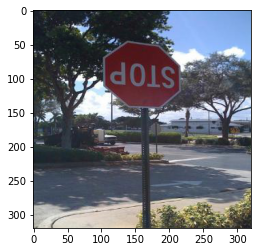

[(1, 10, 10, 255), (1, 20, 20, 255)]


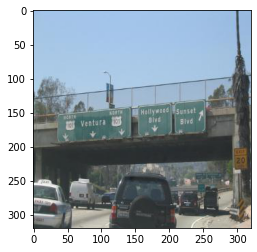

[(1, 10, 10, 255), (1, 20, 20, 255)]


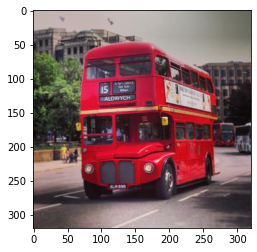

[(1, 10, 10, 255), (1, 20, 20, 255)]


ValueError: ignored

In [ ]:
outputTensorDir = 'C_Outputs'
N_images = 5

for i in range(N_images):
  img_path = os.path.join(dataDir, 'images', dataType,  img_filenames[i])
  img = np.expand_dims(load_img_array(img_path), axis=0)
  # img_id = img_ids[i]

  # yhat = model.predict(img)

  y1_path = os.path.join(outputTensorDir, 'test_bin_response_image' + str(i) + '_10by10by255.float32')
  y2_path = os.path.join(outputTensorDir, 'test_bin_response_image' + str(i) + '_20by20by255.float32')

  y1hat = np.fromfile(y1_path, dtype=np.float32)
  y2hat = np.fromfile(y2_path, dtype=np.float32)

  y1hat = np.reshape(y1hat, (10, 10, 255))
  y2hat = np.reshape(y2hat, (20, 20, 255))

  yhat = [np.expand_dims(y1hat, axis=0), np.expand_dims(y2hat, axis=0)]

  print([a.shape for a in yhat])
  boxes = []
  for i in range(len(yhat)):
    boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)

  # correct the sizes of the bounding boxes for the shape of the image
  correct_yolo_boxes(boxes, 320, 320, 320, 320)

  # Suppress non-maximal (confidences) boxes with high overlap (IoU)
  do_nms(boxes, nms_thresh)

  # Get bounding boxes above score theshold
  v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

  # TODO - only for demo & debug purposes
  draw_boxes(img_path, v_boxes, v_labels, v_scores) 


In [ ]:
print(model.layers)

[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f15c5ac9850>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f15c58b8cd0>, <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f15c5be6a90>, <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x7f15c74daf50>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f15c5b58210>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f15c5ae87d0>, <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f15c5c418d0>, <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x7f15c5bd4710>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f15c5ae3310>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f15c5ae3810>, <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f15c5ae3dd0>, <tensorflow.python.keras.layers.advanced_activations

In [ ]:
a = np.asarray([1.5,2.5,3.5], dtype=np.float32)
a.tofile('bin_test.float32')

In [ ]:
a = np.fromfile('bin_test_response.float32', dtype=np.float32)

In [ ]:
print(a)

[1.5 2.5 3.5]
